In [1]:
# https://www.kaggle.com/iafoss/image-preprocessing-128x128
import cv2
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sys import getsizeof, getrefcount
import psutil
import gc

In [2]:
HEIGHT = 137
WIDTH = 236
SIZE = 224

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img0 = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img0[img0 < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img0 = np.pad(img0, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img0,(size,size))

def proces_image(images):
    """
    images: (batch_size, 32332), np array
    
    """
    image_max = images.max(axis=1).reshape(-1, 1).astype(np.uint8)
    images = (255 - images)/image_max*255
    images = images.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
    
    processed_image_list = []

    for idx in tqdm(range(len(images))):
        processed_image_list.append(crop_resize(images[idx]))

    del image_max
    del images
    print(gc.collect())
    
    return np.array(processed_image_list)

In [3]:
train_df = pd.read_csv("../data/train.csv")

df = pd.read_parquet('../data/train_image_data_0.parquet')
merged_df = df.merge(train_df, on="image_id")

image_name = merged_df["image_id"]
label = merged_df[["grapheme_root","vowel_diacritic","consonant_diacritic"]].astype(np.uint8)
image = merged_df.drop(["image_id", "grapheme_root","vowel_diacritic","consonant_diacritic", "grapheme"], axis=1).values


In [ ]:
# full image processing
image = image * 1

print(getsizeof(image)/1024/1024/1024)
print(psutil.virtual_memory()[4]/1024/1024/1024)

image = proces_image(image)
print(gc.collect())
print(getsizeof(image)/1024/1024/1024)
print(psutil.virtual_memory()[4]/1024/1024/1024)

In [ ]:
with open("train_data_0.pickle", "wb") as f:
    pickle.dump(image, f)

# Step by step

In [4]:
# strange thing in memory
print(getsizeof(image)/1024/1024/1024)
print(psutil.virtual_memory()[4]/1024/1024/1024)
image = image * 1
print(getsizeof(image)/1024/1024/1024)
print(psutil.virtual_memory()[4]/1024/1024/1024)


1.043081283569336e-07
103.45677185058594
1.5118995979428291
103.45483016967773


In [ ]:
print(getsizeof(image)/1024/1024/1024)

image_max = image.max(axis=1).reshape(-1, 1).astype(np.uint8)
print(getsizeof(image_max))

image = (255 - image)/image_max*255
print(getsizeof(image)/1024/1024/1024)

image = image.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
print(getsizeof(image)/1024/1024/1024)


In [8]:
processed_image_list = []

for idx in tqdm(range(len(image))):
    processed_image_list.append(crop_resize(image[idx]))
    

# result_list = []

# for idx in tqdm(range(len(image))):
#     root, vowel, consonant = label.values[idx]
#     result_list.append({
#         "image": crop_resize(image[idx]),
#         "name": image_name[idx],
#         "grapheme_root": root,
#         "vowel_diacritic": vowel,
#         "consonant_diacritic": consonant
#     })

100%|██████████| 50210/50210 [00:47<00:00, 1060.60it/s]


In [9]:
np.array(processed_image_list).shape

(50210, 224, 224)

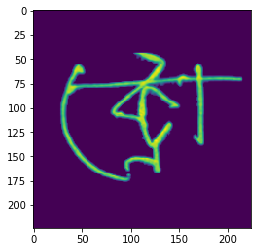

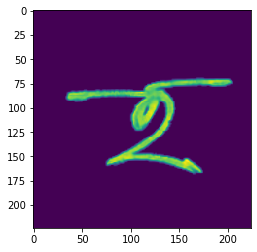

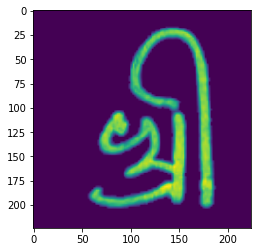

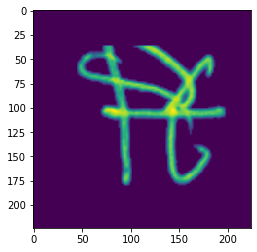

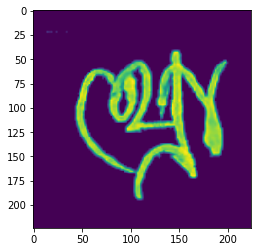

In [10]:
# size 224 X 224 
for i in range(5):
    plt.imshow(processed_image_list[i])
    plt.show()

In [11]:
a = (np.array(processed_image_list), image_name, label.values)

In [12]:
a[2]

array([[ 15,   9,   5],
       [159,   0,   0],
       [ 22,   3,   5],
       ...,
       [ 65,   9,   0],
       [ 24,   0,   0],
       [ 57,   1,   0]], dtype=uint8)

In [13]:
with open("train_data_0.pickle", "wb") as f:
    pickle.dump(a, f)

In [15]:
with open("../data/processed_data/train_data_0.pickle", "rb") as f:
    data_list = pickle.load(f)